1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
Predicted: [('n03450230', 'gown', 0.19088568), ('n03534580', 'hoopskirt', 0.07605634), ('n03424325', 'gasmask', 0.054620285)]


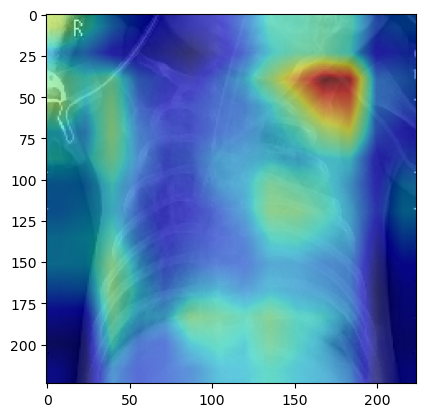

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
import cv2

#original CNN model D:\sem5\MLinHealthCare\ML4H_git\Project1\code\integrated_gradients\our_model.pth
#model with random targets - 70 percent randomization: D:\sem5\MLinHealthCare\ML4H_git\Project1\code\integrated_gradients\our_model_70p_random.pth

def get_grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    output = conv_output[0]
    grads = tape.gradient(loss, conv_output)[0]

    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.dot(output, weights)

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    return heatmap

def get_grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(model.inputs, [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    output = conv_output[0]
    
    # Convert img_array to a TensorFlow tensor
    img_tensor = tf.convert_to_tensor(img_array)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        conv_output, predictions = grad_model(img_tensor)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)[0]
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.dot(output, weights)

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    return heatmap

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Choose an image from your dataset
img_path = '../data/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Get the predictions for the image
preds = model.predict(x)
decoded_preds = decode_predictions(preds, top=3)[0]
print('Predicted:', decoded_preds)

# Choose the layer name from which you want to compute Grad-CAM
layer_name = 'block5_conv3'

# Get Grad-CAM heatmap
heatmap = get_grad_cam(model, x, layer_name)

# Overlay heatmap on the original image
plt.imshow(img)
plt.imshow(heatmap, alpha=0.5, cmap='jet')
plt.show()


In [3]:
!pip install torch-summary

  Using cached torch_summary-1.4.5-py3-none-any.whl.metadata (18 kB)
Using cached torch_summary-1.4.5-py3-none-any.whl (16 kB)


### pytorch implementation

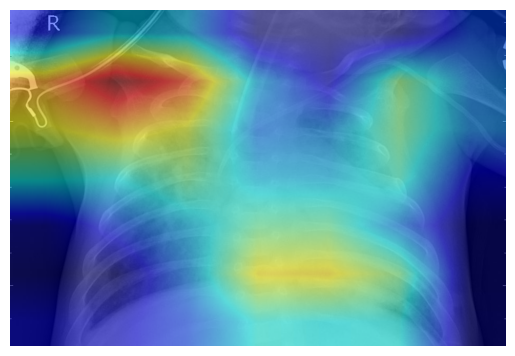

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import models, transforms
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


def load_model(model_path):
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(512, 2)  # Change the last fully connected layer for binary classification
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # Load the pre-trained weights
    model.eval()
    return model

# Load your PyTorch model
model_path = '../code/integrated_gradients/our_model.pth'
model = load_model(model_path)

# Load your PyTorch model on the GPU
model = load_model(model_path).cuda()

# Choose an image from your dataset
img_path = '../data/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg'
img = Image.open(img_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create an input tensor image for your model
# Note: input_tensor can be a batch tensor with several images!
input_tensor = transform(img).unsqueeze(0).cuda()
img_np = np.array(img) / 255.0

# Specify the target layers for Grad-CAM
target_layers = [model.layer4[-1]]
target_class = 1
targets = [ClassifierOutputTarget(target_class)]


# Construct the Grad-CAM object once
cam = GradCAM(model=model, target_layers=target_layers)

# Generate the Class Activation Maps (CAMs)
grayscale_cam = cam(input_tensor=input_tensor,targets=targets)

# Resize the heatmap to match the size of the original input image
heatmap_resized = cv2.resize(grayscale_cam[0], (img_np.shape[1], img_np.shape[0]))

# Visualize the CAM on the original image
visualization = show_cam_on_image(img_np, heatmap_resized, use_rgb=True)

# Display the visualization
plt.imshow(visualization)
plt.axis('off')
plt.show()

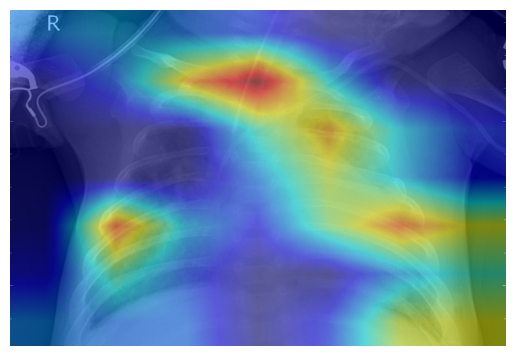

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import models, transforms
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


def load_model(model_path):
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(512, 2)  # Change the last fully connected layer for binary classification
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # Load the pre-trained weights
    model.eval()
    return model

# Load your PyTorch model
model_path = '../code/integrated_gradients/our_model_70p_random.pth'
model = load_model(model_path)

# Load your PyTorch model on the GPU
model = load_model(model_path).cuda()

# Choose an image from your dataset
img_path = '../data/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg'
img = Image.open(img_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create an input tensor image for your model
# Note: input_tensor can be a batch tensor with several images!
input_tensor = transform(img).unsqueeze(0).cuda()
img_np = np.array(img) / 255.0

# Specify the target layers for Grad-CAM
target_layers = [model.layer4[-1]]
target_class = 1
targets = [ClassifierOutputTarget(target_class)]


# Construct the Grad-CAM object once
cam = GradCAM(model=model, target_layers=target_layers)

# Generate the Class Activation Maps (CAMs)
grayscale_cam = cam(input_tensor=input_tensor,targets=targets)

# Resize the heatmap to match the size of the original input image
heatmap_resized = cv2.resize(grayscale_cam[0], (img_np.shape[1], img_np.shape[0]))

# Visualize the CAM on the original image
visualization = show_cam_on_image(img_np, heatmap_resized, use_rgb=True)

# Display the visualization
plt.imshow(visualization)
plt.axis('off')
plt.show()

In [32]:
for name, module in model.named_children():
    print("name:",name, "module:",module)

name: conv1 module: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
name: bn1 module: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
name: relu module: ReLU(inplace=True)
name: maxpool module: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
name: layer1 module: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(i